In [3]:
import os
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.utils import Sequence
from sklearn.preprocessing import LabelBinarizer
from transformers import CLIPProcessor, CLIPModel
from sklearn.metrics import classification_report
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

class DataGenerator(Sequence):
    def __init__(self, data, batch_size, clip_processor, clip_model, data_type, label_binarizer, max_length=77, is_training=True, labeled=True):
        self.data = data
        self.batch_size = batch_size
        self.clip_processor = clip_processor
        self.clip_model = clip_model
        self.label_binarizer = label_binarizer
        self.max_length = max_length
        self.indices = np.arange(len(self.data))
        self.is_training = is_training  
        self.labeled = labeled  
        self.image_dir = data_paths[data_type]['image_dir']

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.data[k] for k in batch_indices]

        if self.labeled:
            X, y = self.preprocess_data(batch)
            if self.is_training:
                return X, y
            else:
                batch_ids = [sample["id"] for sample in batch]
                return X, y, batch_ids
        else:
            X = self.preprocess_data(batch, labeled=False)
            if not self.is_training:
                batch_ids = [sample["id"] for sample in batch]
            return X, batch_ids
      

    def load_image(self, image_path):
        try:
            with Image.open(image_path) as img:
                return img.convert('RGB')
        except IOError:
            print(f"Error in loading image: {image_path}. Using a placeholder image.")
            return Image.new('RGB', (224, 224), color='white')
        
    def preprocess_data(self, batch, labeled=True):
        texts = [sample["text"] for sample in batch]
        image_filenames = [sample["image"] for sample in batch]
        
        if labeled:
            labels = [sample["label"] for sample in batch]
            y = self.label_binarizer.transform(labels)
        else:
            y = []
            
        processed_texts = self.clip_processor(text=[text[:self.max_length] for text in texts], return_tensors="pt", padding=True, truncation=True)
        inputs = {k: v.to(self.clip_model.device) for k, v in processed_texts.items()}
        text_embeddings = self.clip_model.get_text_features(**inputs).cpu().detach().numpy()

        images = [self.load_image(os.path.join(self.image_dir, filename)) for filename in image_filenames]
        processed_images = self.clip_processor(images=images, return_tensors="pt")
        image_embeddings = self.clip_model.get_image_features(**processed_images).cpu().detach().numpy()
        combined_embeddings = np.concatenate((text_embeddings, image_embeddings), axis=1)
        
        if labeled:
            return combined_embeddings, y
        else:
            return combined_embeddings

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

class BinaryMemeClassification:       
    def __init__(self, data_paths):
        self.label_binarizer = LabelBinarizer()
        self.clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        self.clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        self.model = None
        self.data_paths = data_paths 
        
        
    def load_and_preprocess_data(self, data_type, sample_size=None):
        #select the file and image paths based on the data_type
        data_info = self.data_paths.get(data_type)
        if not data_info:
            raise ValueError(f"Invalid data type: {data_type}")

        json_file_path = data_info.get('json_path')
        image_dir = data_info.get('image_dir')

        #load JSON data
        with open(json_file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)
        if sample_size:
            data = np.random.choice(data, sample_size, replace=False)

        #handling labels differently based on data_type
        if data_type in ['train', 'dev']:
            labels = [sample.get("label") for sample in data]
            self.label_binarizer.fit(labels)
        else:
            labels = []

        return data
            
    def explore_data(self, sample_size=None, data_type='train', labeled=True, examples_to_show=2):
        data = self.load_and_preprocess_data(data_type, sample_size)

        print(f"Total number of samples: {len(data)}")
        unique_labels = set(sample.get("label") for sample in data)
        print(f"Total number of unique labels: {len(unique_labels)}")
        print("Unique labels:", unique_labels)
        
        data_generator = DataGenerator(data, batch_size=1, clip_processor=self.clip_processor, clip_model=self.clip_model, label_binarizer=self.label_binarizer, data_type=data_type)

        for i in range(examples_to_show):
            sample = [data[i]]
            combined_embeddings = data_generator.preprocess_data(sample, labeled=labeled)

            print(f"\nSample {i+1}:")
            print("Text:", sample[0]["text"])
            print("Image:", sample[0]["image"])
            print("Combined Embedding Shape:", combined_embeddings.shape)
            print("Combined Embedding:", combined_embeddings)
            

    def build_model(self, embedding_size=1024, dropout_rate=0.5, learning_rate=0.005):
        input_layer = Input(shape=(embedding_size,), dtype='float32', name="input")
        dense_layer = Dense(1024, activation='relu')(input_layer)
        dropout_layer = Dropout(dropout_rate)(dense_layer)
        output_layer = Dense(1, activation='sigmoid')(dense_layer)  # Binary output

        self.model = Model(inputs=input_layer, outputs=output_layer)
        optimizer = Adam(learning_rate=learning_rate)
        self.model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

        return self.model

    def train_model(self, save_model_path, batch_size=32, epochs=5, data_type='train', validation_size=0.2, learning_rate=0.005, random_state=42, sample_size=None):
        data = self.load_and_preprocess_data(data_type, sample_size)

        #split data into training and validation sets
        X_train_indices, X_val_indices = train_test_split(
            range(len(data)), test_size=validation_size, random_state=random_state
        )

        #generate training and validation data using indices
        train_data = [data[i] for i in X_train_indices]
        val_data = [data[i] for i in X_val_indices]

        #initialize data generators
        train_generator = DataGenerator(train_data, batch_size, self.clip_processor, self.clip_model, data_type, self.label_binarizer, is_training=True)
        val_generator = DataGenerator(val_data, batch_size, self.clip_processor, self.clip_model, data_type, self.label_binarizer, is_training=True)

        #compute class weights
        labels = [sample["label"] for sample in train_data]
        class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
        class_weights = dict(enumerate(class_weights))

        model = self.build_model(embedding_size=1024, dropout_rate=0.5, learning_rate=learning_rate)

        early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

        history = model.fit(train_generator, epochs=epochs, validation_data=val_generator, class_weight=class_weights, callbacks=[early_stopping])

        model.save_weights(save_model_path)
        print(f"model saved at {save_model_path}")

        return history
    

    def plot_training_history(self, history):
        plt.figure(figsize=(10, 4))
        
        #plot accuracy
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(['Train', 'Validation'], loc='upper left')

        #plot loss 
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(['Train', 'Validation'], loc='upper left')
        
        plt.tight_layout()
        plt.show()      

    def calculate_hierarchy_distance(self, node1, node2):
        def find_path(tree, node, path=[]):
            if node in tree:
                return path + [node]
            for k, v in tree.items():
                if isinstance(v, dict):
                    new_path = find_path(v, node, path + [k])
                    if new_path:
                        return new_path
            return []

        node1_tuple = (node1,) if isinstance(node1, str) else node1
        node2_tuple = (node2,) if isinstance(node2, str) else node2

        path1 = find_path(self.label_tree, node1_tuple)
        path2 = find_path(self.label_tree, node2_tuple)

        common_length = len(set(path1) & set(path2))
        distance = len(path1) + len(path2) - 2 * common_length
        return distance
    

    def evaluate_model(self, batch_size, save_model_path, output_json_path, data_type='dev'):
        # Load and preprocess test data
        dev_data = self.load_and_preprocess_data(data_type)
        test_generator = DataGenerator(dev_data, batch_size, self.clip_processor, self.clip_model, data_type, self.label_binarizer, is_training=False)

        #build the model and load saved weights
        self.build_model()
        self.model.load_weights(save_model_path)

        # Variables for metrics calculation
        true_labels_all = []
        predicted_labels_all = []
        
        results = [] 
        for X, y_true, batch_ids in test_generator:
            y_pred = self.model.predict(X)

            #iterate over predictions in the batch
            for sample_id, prediction, true_label in zip(batch_ids, y_pred, y_true):
                gold_label = self.label_binarizer.classes_[0] if true_label == 0 else self.label_binarizer.classes_[1]
                predicted_label = self.label_binarizer.classes_[0] if prediction < 0.5 else self.label_binarizer.classes_[1]

               #probability of the classes
                positive_prob = float(prediction[0])  # Assuming the model outputs a single probability per sample
                predicted_label_prob = positive_prob if predicted_label == self.label_binarizer.classes_[1] else 1 - positive_prob
                
                true_labels_all.append(gold_label)
                predicted_labels_all.append(predicted_label)

                results.append({
                    'id': sample_id,
                    'ture_label': gold_label,
                    'predicted_label': predicted_label,            
                    'predicted_label_probability': predicted_label_prob               
                
                })     

        #print classification report
        print("Classification Report:")
        print(classification_report(true_labels_all, predicted_labels_all, target_names=self.label_binarizer.classes_))
        
        result_file_name = f"subtask2b_dev_pred.json"
        destination_path = os.path.join(output_json_path, result_file_name)
        os.makedirs(output_json_path, exist_ok=True)
        with open(destination_path, 'w') as json_file:
            json.dump(results, json_file, indent=4)
    
    def test_model(self, batch_size, save_model_path, output_json_path, data_type='test'):
        #load the test data
        test_data = self.load_and_preprocess_data(data_type)
        test_generator = DataGenerator(test_data, batch_size, self.clip_processor, self.clip_model, data_type, self.label_binarizer, is_training=False, labeled=False)

        #load the trained model weights
        self.build_model()
        self.model.load_weights(save_model_path)

        predictions = []

        #generate predictions
        for X, batch_ids in test_generator:
            y_pred = self.model.predict(X)
            print("Raw predictions:", y_pred)
            for sample_id, prediction in zip(batch_ids, y_pred):
                #determine the predicted label based on the threshold
                predicted_label = self.label_binarizer.classes_[0] if prediction < 0.5 else self.label_binarizer.classes_[1]
               
               #probability of the classes
                positive_prob = float(prediction[0])  # Assuming the model outputs a single probability per sample
                predicted_label_prob = positive_prob if predicted_label == self.label_binarizer.classes_[1] else 1 - positive_prob
                predictions.append({
                    'id': sample_id,
                    'predicted_label': predicted_label,
                    'predicted_label_probability': predicted_label_prob
                
                })

        #save the predictions to a JSON file
        result_file_name = "subtask2b_test_pred.json"
        destination_path = os.path.join(output_json_path, result_file_name)
        os.makedirs(output_json_path, exist_ok=True)
        with open(destination_path, 'w') as json_file:
            json.dump(predictions, json_file, indent=4)
            
        return "Predictions completed."

    

batch_size = 32
num_classes = 23
output_json_path = '/Users/jamessmith/Desktop/Desktop/SemEval_Task/data/dev_gold_labels'
save_model_path = '/Users/jamessmith/Desktop/Desktop/SemEval_Task/data/subtask2b/CLIP_model_weights'

data_paths = {
    'train': {
        'json_path': '/Users/jamessmith/Desktop/Desktop/SemEval_Task/data/subtask2b/final_file.json',
        'image_dir': '/Users/jamessmith/Desktop/Desktop/SemEval_Task/data/subtask2b/final_images'

    },
    'dev': {
        'json_path': '/Users/jamessmith/Desktop/Desktop/SemEval_Task/data/dev_gold_labels/dev_subtask2b_en.json',
        'image_dir': '/Users/jamessmith/Desktop/Desktop/SemEval_Task/data/subtask2b_images/dev'
    },
    'test': {
        'json_path': '/Users/jamessmith/Desktop/Desktop/SemEval_Task/data/test_data/english/en_subtask2b_test_unlabeled.json',
        'image_dir': '/Users/jamessmith/Desktop/Desktop/SemEval_Task/data/test_data/test_images/subtask2b/english'
    }
}


CLIP_meme_classifier2b = BinaryMemeClassification(data_paths)



In [4]:
CLIP_meme_classifier2b.explore_data(data_type='train', 
                                    labeled=False, 
                                    examples_to_show=2
                                   )


Total number of samples: 6021
Total number of unique labels: 2
Unique labels: {'propagandistic', 'non_propagandistic'}

Sample 1:
Text: THIS IS WHY YOU NEED\n\nA SHARPIE WITH YOU AT ALL TIMES
Image: prop_meme_4839.png
Combined Embedding Shape: (1, 1024)
Combined Embedding: [[-0.08991271 -0.14774483 -0.12246765 ...  0.00429224  0.06807035
  -0.12142507]]

Sample 2:
Text: GOOD NEWS!\n\nNAZANIN ZAGHARI-RATCLIFFE AND ANOOSHEH ASHOORI HAVE BEEN RELEASED\n\nAfter years of being unjustly detained in Iran, they are making their way safely back to the UK.
Image: prop_meme_7653.png
Combined Embedding Shape: (1, 1024)
Combined Embedding: [[ 0.03004405  0.01037037 -0.32822505 ...  0.20906326  0.16145945
  -0.01518326]]


In [5]:
history= CLIP_meme_classifier2b.train_model(
                                          save_model_path, 
                                          batch_size=32, 
                                          epochs=10,
                                          learning_rate=0.0001,
                                          data_type='train'
                                         )

Epoch 1/10
151/151 [==============================] - 403s 3s/step - loss: 0.5633 - accuracy: 0.7141 - val_loss: 0.4652 - val_accuracy: 0.7817
Epoch 2/10
151/151 [==============================] - 422s 3s/step - loss: 0.4495 - accuracy: 0.7778 - val_loss: 0.4762 - val_accuracy: 0.7768
Epoch 3/10
151/151 [==============================] - 822s 5s/step - loss: 0.3972 - accuracy: 0.8171 - val_loss: 0.4181 - val_accuracy: 0.8149
Epoch 4/10
151/151 [==============================] - 824s 5s/step - loss: 0.3573 - accuracy: 0.8420 - val_loss: 0.4101 - val_accuracy: 0.8224
Epoch 5/10
151/151 [==============================] - 408s 3s/step - loss: 0.3242 - accuracy: 0.8607 - val_loss: 0.3991 - val_accuracy: 0.8282
Epoch 6/10
151/151 [==============================] - 413s 3s/step - loss: 0.2944 - accuracy: 0.8802 - val_loss: 0.3445 - val_accuracy: 0.8365
Epoch 7/10
151/151 [==============================] - 419s 3s/step - loss: 0.2626 - accuracy: 0.8958 - val_loss: 0.4035 - val_accuracy: 0.8166

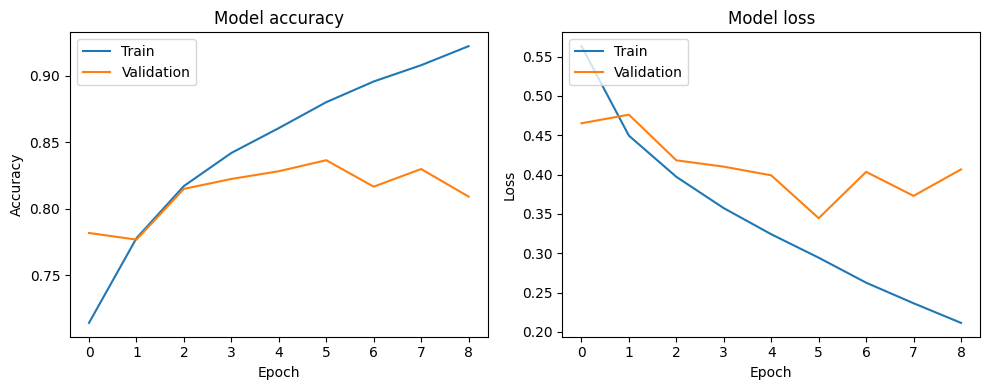

In [6]:
CLIP_meme_classifier2b.plot_training_history(history)

In [7]:
#evaluate the model using the dev set
CLIP_meme_classifier2b.evaluate_model(
                                    batch_size=batch_size, 
                                    save_model_path=save_model_path, 
                                    output_json_path=output_json_path, 
                                    data_type='dev'
                                    )


1/1 [==============================] - 0s 22ms/step
Classification Report:
                    precision    recall  f1-score   support

non_propagandistic       0.53      0.42      0.47       100
    propagandistic       0.74      0.81      0.77       200

          accuracy                           0.68       300
         macro avg       0.63      0.61      0.62       300
      weighted avg       0.67      0.68      0.67       300



In [8]:
#get predictions on the unlabeled test data
CLIP_meme_classifier2b.test_model(batch_size, 
                                save_model_path, 
                                output_json_path,
                                data_type='test'
                               )

1/1 [==============================] - 0s 22ms/step
Raw predictions: [[0.3717662 ]
 [0.5815552 ]
 [0.11232707]
 [0.99652755]
 [0.8355092 ]
 [0.78353757]
 [0.09147341]
 [0.11622122]
 [0.5812309 ]
 [0.65343463]
 [0.9706004 ]
 [0.21609123]
 [0.7260424 ]
 [0.74234086]
 [0.6791149 ]
 [0.9741692 ]
 [0.8604018 ]
 [0.86234236]
 [0.98861116]
 [0.26368323]
 [0.81476194]
 [0.86731213]
 [0.97816074]
 [0.993262  ]
 [0.07751725]
 [0.9644728 ]
 [0.8493131 ]
 [0.9897734 ]
 [0.9694813 ]
 [0.9921881 ]
 [0.9401662 ]
 [0.9358659 ]]
1/1 [==============================] - 0s 9ms/step
Raw predictions: [[0.9472878 ]
 [0.9943417 ]
 [0.2336066 ]
 [0.73250276]
 [0.76974046]
 [0.9837135 ]
 [0.95374644]
 [0.976794  ]
 [0.10102884]
 [0.56881183]
 [0.9533358 ]
 [0.03162925]
 [0.9937925 ]
 [0.85215247]
 [0.10158335]
 [0.7175283 ]
 [0.9334522 ]
 [0.78589904]
 [0.79627043]
 [0.9987044 ]
 [0.5079182 ]
 [0.7822717 ]
 [0.42278782]
 [0.3116846 ]
 [0.1719658 ]
 [0.5459212 ]
 [0.06232404]
 [0.5903391 ]
 [0.37062493]
 [0.9993

'Predictions completed.'